## Importing libraries

In [38]:
import os
import gurobipy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

stop_time = 3600 #set time limit for MIP approach 

## Q1) Reading datasets and calculating corr matrix

In [39]:
#Reading 2019 and 2020 datasets
data_2019 = pd.read_csv("stocks2019.csv")
data_2020 = pd.read_csv("stocks2020.csv")

In [40]:
print(data_2019.head())
print(data_2020.head())

            X          NDX       ATVI        ADBE        AMD        ALXN   
0  2019-01-02  6360.870117  46.350380  224.570007  18.830000   98.050003  \
1  2019-01-03  6147.129883  44.704514  215.699997  17.049999  100.209999   
2  2019-01-04  6422.669922  46.488358  226.190002  19.000000  106.000000   
3  2019-01-07  6488.250000  47.799141  229.259995  20.570000  107.940002   
4  2019-01-08  6551.850098  49.247898  232.679993  20.750000  108.610001   

         ALGN        GOOGL         GOOG         AMZN  ...       TCOM   
0  202.119995  1054.680054  1045.849976  1539.130005  ...  27.590000  \
1  184.779999  1025.469971  1016.059998  1500.280029  ...  26.959999   
2  186.710007  1078.069946  1070.709961  1575.390015  ...  28.549999   
3  189.919998  1075.920044  1068.390015  1629.510010  ...  29.180000   
4  192.949997  1085.369995  1076.280029  1656.579956  ...  29.480000   

         ULTA        VRSN        VRSK        VRTX        WBA        WDAY   
0  247.970001  147.759995  107.364

In [41]:
#storing daily index values in both datasets
index_2019 = data_2019[['X','NDX']]
index_2020 = data_2020[['X','NDX']]

#Storing daily index returns in both datasets
q_2019 = data_2019['NDX'].pct_change().reset_index().set_index('index')
q_2020 = data_2020['NDX'].pct_change().reset_index().set_index('index')

#dropping index column from both the datasets
data_2019.drop('NDX',axis=1,inplace=True)
data_2020.drop('NDX',axis=1,inplace=True)

In [42]:
#Calculating corr matrices for both dataframes

#2019
data_2019.set_index('X', inplace=True)
data_2019_pct = data_2019.pct_change()
data_corr_2019 = data_2019_pct.corr()

#2020
data_2020.set_index('X', inplace=True)
data_2020_pct = data_2020.pct_change()
data_corr_2020 = data_2020_pct.corr()

print(data_corr_2019.head())
print(data_corr_2020.head())



          ATVI      ADBE       AMD      ALXN      ALGN     GOOGL      GOOG   
ATVI  1.000000  0.399939  0.365376  0.223162  0.216280  0.433097  0.426777  \
ADBE  0.399939  1.000000  0.452848  0.368928  0.363370  0.552125  0.540404   
AMD   0.365376  0.452848  1.000000  0.301831  0.344252  0.418861  0.417254   
ALXN  0.223162  0.368928  0.301831  1.000000  0.332433  0.315993  0.307698   
ALGN  0.216280  0.363370  0.344252  0.332433  1.000000  0.248747  0.250316   

          AMZN      AMGN       ADI  ...      TCOM      ULTA      VRSN   
ATVI  0.467076  0.203956  0.329355  ...  0.322906  0.128241  0.464850  \
ADBE  0.598237  0.291978  0.473815  ...  0.360392  0.201151  0.711339   
AMD   0.549302  0.151452  0.503733  ...  0.332776  0.210623  0.498342   
ALXN  0.363170  0.342022  0.317040  ...  0.257143  0.408936  0.350581   
ALGN  0.399281  0.264599  0.328280  ...  0.175957  0.128559  0.360886   

          VRSK      VRTX       WBA      WDAY       WDC       XEL      XLNX  
ATVI  0.316549 

In [43]:
data_2019_pct.dropna(axis=0,inplace=True)
data_2020_pct.dropna(axis=0,inplace=True)
q_2019.dropna(axis=0,inplace=True)
q_2020.dropna(axis=0,inplace=True)
q_2019 = np.array(q_2019)
q_2020 = np.array(q_2020)

In [44]:
#storing number of records in correlation matrices
records_2019 = data_corr_2019.shape[1]
records_2020 = data_corr_2020.shape[1]

## Q2) Choosing the 5 best stocks and calculating there weights

In [45]:
#stock selection
m=5
model = gp.Model()

#Creating 100*100 xij decision variables for 
xij = model.addMVar((records_2019,records_2019),vtype = 'b')
y = model.addMVar(records_2019,vtype = 'b')

#objective for choosing best stocks (maximizing sum of correlation)
model.setObjective(gp.quicksum(xij[i,j]*data_corr_2019.iloc[i,j] for j in range(records_2019) for i in range(records_2019)), sense = gp.GRB.MAXIMIZE)

#constraint 1 (ensuring only one xij in each column is chosen)
model.addConstrs((gp.quicksum(xij[i,j] for j in range(records_2019)) == 1) for i in range(records_2019))

#constraint 2 (Ensuring that only 'm' stocks are picked)
model.addConstr(gp.quicksum(y[i] for i in range(records_2019)) == m)

#constraint 3 (logical constraint)
model.addConstrs(xij[i,j] <= y[j] for j in range(records_2019) for i in range(records_2019))

model.Params.OutputFlag = 0 # tell gurobi to shut up!!
model.optimize()

In [46]:
stocks = data_2019_pct.columns.tolist()
selected_stocks = [stocks[i] for i in range(records_2019) if y.x[i] == 1]
print(f'Selected stocks are:', selected_stocks)

Selected stocks are: ['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']


In [47]:
print(model.objVal)

54.83990652229107


In [48]:
rit_2019 = data_2019_pct[selected_stocks].values
T = len(q_2019)

In [49]:
rit_2019.shape

(250, 5)

In [50]:
T

250

In [51]:
#weights selection
model= gp.Model()
w=model.addMVar(m, vtype='C')
ys= model.addMVar(T, vtype='C')

#setting objective
model.setObjective(gp.quicksum(ys[i] for i in range(T)), sense=gp.GRB.MINIMIZE)

#adding constraints to convert non-linear absolute objective to linear
model.addConstrs((q_2019[t]-gp.quicksum(w[i]*rit_2019[t,i] for i in range(m))) <= ys[t]for t in range(T))
model.addConstrs((gp.quicksum(w[i]*rit_2019[t,i] for i in range(m))-q_2019[t]) <= ys[t] for t in range(T))


model.addConstr(gp.quicksum(w[i] for i in range(m))==1)

model.Params.OutputFlag = 0
model.optimize()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [52]:
model.objVal

0.7891782824631473

In [53]:
w.x

array([0.04886175, 0.21038806, 0.58035198, 0.07119022, 0.089208  ])

Text(0, 0.5, '% Weight')

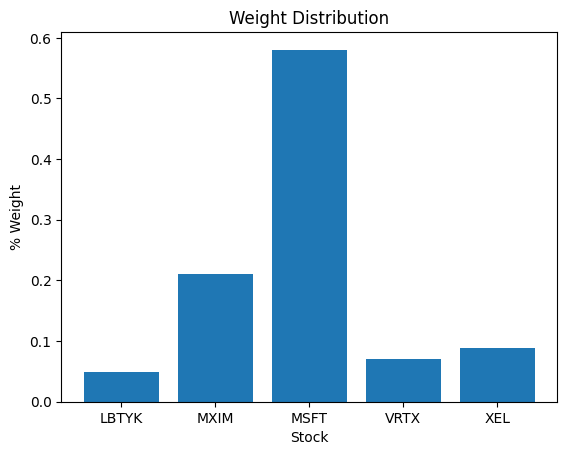

In [54]:
plt.bar(selected_stocks, w.x)
plt.title("Weight Distribution")
plt.xlabel('Stock')
plt.ylabel('% Weight') 

In [55]:
#evaluating performance on 2020 data using above weights
rit_2020 = data_2020_pct[selected_stocks].values
abs_dev_2020 = 0

for i in range(len(data_2020_pct)):
    wr = 0
    for j in range(len(selected_stocks)):
        wr = wr + (w.x[j]*rit_2020[i][j])       
    s = abs(q_2020[i] - wr) 
    abs_dev_2020 = abs_dev_2020 + s
    
print ("\nAbsolute Deviation for year 2020 is:", abs_dev_2020)



Absolute Deviation for year 2020 is: [1.11243735]


Text(0, 0.5, 'Returns')

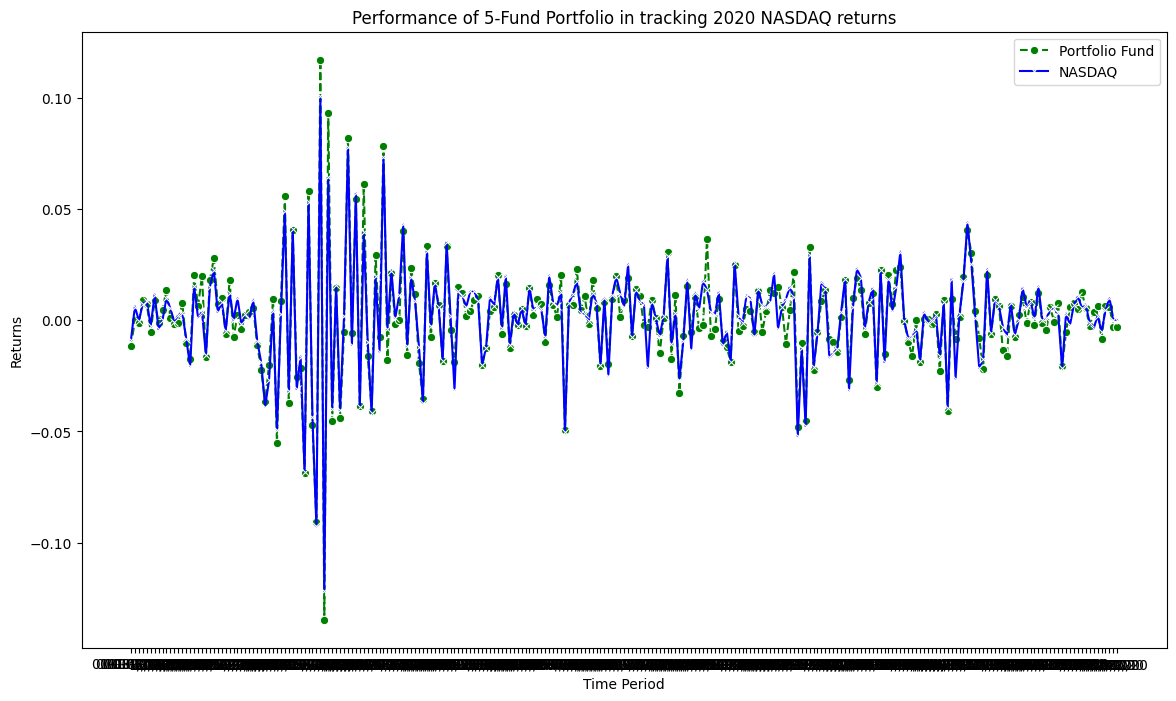

In [56]:
#plotting daily return comparison graph of index and our funds
returns_timeline = data_2020_pct.index
weighted_returns = []

#Computing weighted returns
for i in range(len(data_2020_pct)):
    wr = 0
    for j in range(len(selected_stocks)):
        wr = wr + (w.x[j]*rit_2020[i][j])
    weighted_returns.append(wr)

plt.figure(figsize = (14,8))

#Plotting weighted returns from 2020 for selected stocks
sns.lineplot(x = returns_timeline, y = np.array(weighted_returns), marker = 'o', 
            linestyle = 'dashed', color = 'green', label = 'Portfolio Fund')

#Plotting returns from 2020 for NASDAQ
sns.lineplot(x = returns_timeline, y = q_2020.ravel(), marker = 'x',
             color = 'blue', label = 'NASDAQ')

plt.title("Performance of 5-Fund Portfolio in tracking 2020 NASDAQ returns")
plt.xlabel('Time Period')
plt.ylabel('Returns')      

# Q3) Evaluating performance for m = [5,10,20,30,40,50,60,70,80,90,100]

In [57]:
perf_2019 = []
perf_2020 = []

no_of_stocks = [5,10,20,30,40,50,60,70,80,90,100]

for m in no_of_stocks:
    if m <= data_2019.shape[1]:
        
      
        
        print(f'For m = {m}')
        
        #stock selection
        model = gp.Model()

        #Creating 100*100 xij decision variables for 
        xij = model.addMVar((records_2019,records_2019),vtype = 'b')
        y = model.addMVar(records_2019,vtype = 'b')

        #objective for choosing best stocks (maximizing sum of correlation)
        model.setObjective(gp.quicksum(xij[i,j]*data_corr_2019.iloc[i,j] for j in range(records_2019) for i in range(records_2019)), sense = gp.GRB.MAXIMIZE)

        #constraint 1 (ensuring only one xij in each column is chosen)
        model.addConstrs((gp.quicksum(xij[i,j] for j in range(records_2019)) == 1) for i in range(records_2019))

        #constraint 2 (Ensuring that only 'm' stocks are picked)
        model.addConstr(gp.quicksum(y[i] for i in range(records_2019)) == m)

        #constraint 3 (logical constraint)
        model.addConstrs(xij[i,j] <= y[j] for j in range(records_2019) for i in range(records_2019))

        model.Params.OutputFlag = 0 # tell gurobi to shut up!!
        model.optimize()
        
        stocks = data_2019_pct.columns.tolist()
        selected_stocks = [stocks[i] for i in range(records_2019) if y.x[i] == 1]
        print(f'Selected stocks are:', selected_stocks)
        
        rit_2019 = data_2019_pct[selected_stocks].values
        rit_2020 = data_2020_pct[selected_stocks].values
        T = len(q_2019)
        
        #weights selection
        model= gp.Model()
        w=model.addMVar(m, vtype='C')
        ys= model.addMVar(T, vtype='C')

        #setting objective
        model.setObjective(gp.quicksum(ys[i] for i in range(T)), sense=gp.GRB.MINIMIZE)

        #adding constraints to convert non-linear absolute objective to linear
        model.addConstrs((q_2019[t]-gp.quicksum(w[i]*rit_2019[t,i] for i in range(m))) <= ys[t]for t in range(T))
        model.addConstrs((gp.quicksum(w[i]*rit_2019[t,i] for i in range(m))-q_2019[t]) <= ys[t] for t in range(T))


        model.addConstr(gp.quicksum(w[i] for i in range(m))==1)

        model.Params.OutputFlag = 0
        model.optimize()
        
        print(f'Weights of selected stocks are: {w.x}')
        
        #evaluating performance on 2019 data using above weights
        abs_dev_2019 = 0

        for i in range(len(data_2019_pct)):
            wr = 0
            for j in range(len(selected_stocks)):
                wr = wr + (w.x[j]*rit_2019[i][j])       
            s = abs(q_2019[i] - wr) 
            abs_dev_2019 = abs_dev_2019 + s

        print ("\nAbsolute Deviation for year 2019 is:", abs_dev_2019)
        perf_2019.append(abs_dev_2019)
        
        #evaluating performance on 2020 data using above weights
        abs_dev_2020 = 0

        for i in range(len(data_2020_pct)):
            wr = 0
            for j in range(len(selected_stocks)):
                wr = wr + (w.x[j]*rit_2020[i][j])       
            s = abs(q_2020[i] - wr) 
            abs_dev_2020 = abs_dev_2020 + s

        print ("\nAbsolute Deviation for year 2020 is:", abs_dev_2020)
        perf_2020.append(abs_dev_2020)
        
    else:
        print("No of stocks chosen exceeded the maximum available stocks!!")

For m = 5
Selected stocks are: ['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Weights of selected stocks are: [0.04886175 0.21038806 0.58035198 0.07119022 0.089208  ]

Absolute Deviation for year 2019 is: [0.78917828]

Absolute Deviation for year 2020 is: [1.11243735]
For m = 10
Selected stocks are: ['ATVI', 'ALGN', 'EXPE', 'KHC', 'LBTYK', 'MXIM', 'MSFT', 'ROST', 'VRTX', 'XEL']
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Weights of selected stocks are: [0.04420008 0.02499587 0.02150098 0.02338931 0.03783494 0.15698581
 0.49103052 0.0911518  0.04621603 0.06269464]

Absolute Deviation for year 2019 is: [0.7012178]

Absolute Deviation for year 2020 is: [1.1024044]
For m = 20
Selected stocks are: ['ATVI', 'ALGN', 'GOOGL', 'ANSS', 'ADP', 'BIIB', 'CHTR', 'DLTR', 'EXPE', 'JD', 'KHC', 'LBTYK', 'MXIM', 'MSFT', 'MRNA', 'PCAR', 'PDD', 'ULTA', 'VRTX', 'XEL']
Warning for adding constraints: zer


Absolute Deviation for year 2019 is: [0.14768253]

Absolute Deviation for year 2020 is: [0.53732277]
For m = 90
Selected stocks are: ['ATVI', 'ADBE', 'AMD', 'ALXN', 'ALGN', 'GOOG', 'AMZN', 'AMGN', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'ADSK', 'ADP', 'BIDU', 'BIIB', 'BMRN', 'BKNG', 'AVGO', 'CDW', 'CERN', 'CHTR', 'CHKP', 'CTAS', 'CSCO', 'CTXS', 'CTSH', 'CMCSA', 'CPRT', 'COST', 'CSX', 'DXCM', 'DOCU', 'DLTR', 'EBAY', 'EA', 'EXC', 'EXPE', 'FB', 'FAST', 'FISV', 'GILD', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 'JD', 'KHC', 'LBTYA', 'LULU', 'MAR', 'MELI', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MNST', 'NTES', 'NFLX', 'NVDA', 'ORLY', 'PCAR', 'PAYX', 'PYPL', 'PEP', 'PDD', 'QCOM', 'REGN', 'ROST', 'SGEN', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TMUS', 'TTWO', 'TSLA', 'TCOM', 'ULTA', 'VRSN', 'VRSK', 'VRTX', 'WBA', 'WDAY', 'WDC', 'XEL', 'XLNX']
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Weights of selected stocks are: [0.00407211 0.02050008 0.00443415 0.00419871 0.000134

In [58]:
#Creating a dataframe to store Total Absolute Deviations with NASDAQ for different portfolios for both 2019 and 2020
summary_df = pd.DataFrame(data=[np.append(np.array([5]),np.array(range(10,110,10))),perf_2019, perf_2020]).T
summary_df.rename(columns={0: 'm', 1: 'Performance on 2019 Data', 2: 'Performance on 2020 Data'}, inplace=True)
summary_df = summary_df.set_index('m')
print("Absolute Deviation of Portfolio Fund with NASDAQ for 2019 and 2020 for various values of m:\n")

summary_df.dropna(axis=0,how='all',inplace=True) #removing any NaN rows in case no. of stocks in file is <100
summary_df

Absolute Deviation of Portfolio Fund with NASDAQ for 2019 and 2020 for various values of m:



,Performance on 2019 Data,Performance on 2020 Data
m,,
5,[0.7891782824631473],[1.1124373455076468]
10,[0.7012177959266302],[1.1024044007151048]
20,[0.4662681416517702],[0.8554460015414783]
30,[0.4097923638636839],[0.7673668495630364]
40,[0.3632810268101053],[0.7678907459578618]
50,[0.3325400929154758],[0.7720996592107847]
60,[0.3520564065645237],[1.1649319541645191]
70,[0.23314276300706674],[0.8618932719653669]
80,[0.14768252800096157],[0.5373227700587154]


Text(0, 0.5, 'Total Absolute Deviation')

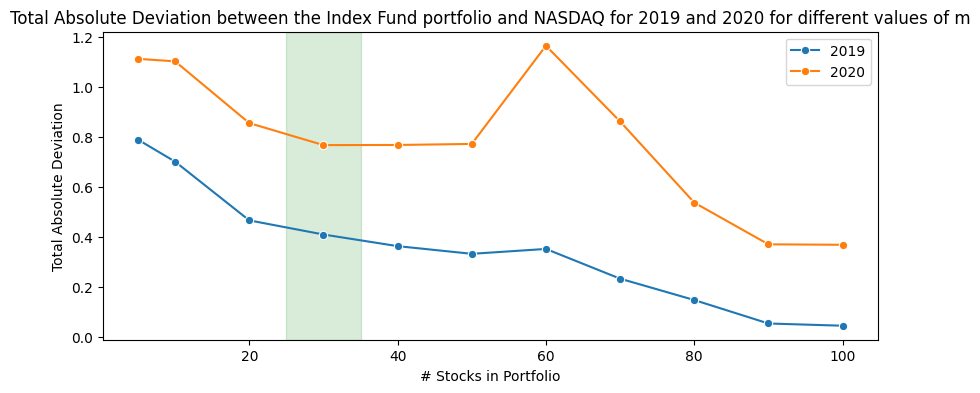

In [59]:
#Converting list to numpy array
perf_2019 = np.array(perf_2019)
perf_2020 = np.array(perf_2020)

#Now we will plot the Total Absolute Deviation between the Index Fund portfolio and NASDAQ for 2019 and 2020 for different values of m
plt.figure(figsize = (10,4))
sns.lineplot(x = summary_df.index.values, y= perf_2019.ravel(), label = "2019", marker = "o")
sns.lineplot(x = summary_df.index.values, y= perf_2020.ravel(), label = "2020", marker = "o" )
plt.title("Total Absolute Deviation between the Index Fund portfolio and NASDAQ for 2019 and 2020 for different values of m")
plt.axvspan(25, 35, color='g', alpha=0.15)
plt.xlabel("# Stocks in Portfolio")
plt.ylabel("Total Absolute Deviation")

## Q4) Mixed Integer Solution (without stock selection part)

In [60]:
perf_2019 = []
perf_2020 = []
n = 100
p = len(data_2019_pct)
M = 100
a = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

#check if file already exists
if os.path.exists("portfolio_grp4.csv"):
    print("file exists..no need to run the code")
else:
    #Creating a pandas dataframe so that we can output it as a CSV file
    output_file=pd.DataFrame(columns = ['m', 'Stocks Selected', 'Weights','Absolute Deviation 2019','Absolute Deviation 2020','Execution Time (Sec)'])

    for k,m in enumerate(a):
        print(f'For m = {m}')
        # Defining the model - Mixed Integer Programming
        model = gp.Model()
        # Defining the variables
        y = model.addMVar(n, vtype = 'B')
        w = model.addMVar(n)
        z = model.addMVar(p)
        model.setObjective(gp.quicksum(z[i] for i in range(p)), gp.GRB.MINIMIZE)
        # Adding Constraints
        model.addConstr(gp.quicksum(w[i] for i in range(n)) == 1)
        model.addConstr(gp.quicksum(y[i] for i in range(n)) == m)
        model.addConstrs(w[i] <= M*y[i]  for i in range(n))
        # Adding two constraints to make absolute value function as an LP
        model.addConstrs(z[i] >= q_2019[i] -
                       gp.quicksum(w[j]*data_2019_pct.iloc[i,j] for j in range(n))
                       for i in range(p))
        model.addConstrs(z[i] >= gp.quicksum(w[j]*data_2019_pct.iloc[i,j] for j in range(n))
                       - q_2019[i] for i in range(p))
        model.Params.OutputFlag = 0
        model.Params.TimeLimit = stop_time 
        model.optimize()

        runtime = model.Runtime

        itemindex = np.where(y.x == 1) #storing index value for selected stocks
        list_of_selected_stocks=data_corr_2019.index.values[itemindex].tolist()
        print("Selected Stocks are: ",list_of_selected_stocks)
        weights = w.x[itemindex]
        print("\nWeights are:",weights)

        #Storing the returns of only these stocks in a new dataframe
        selected_stocks_returns = data_2019_pct[list_of_selected_stocks]
        selected_stocks_returns_array = selected_stocks_returns.to_numpy()

        #Storing the returns of only these stocks in a new dataframe for 2020
        selected_stocks_returns_2020 = data_2020_pct[list_of_selected_stocks]
        selected_stocks_returns_array_2020 = selected_stocks_returns_2020.to_numpy()

        #Now we will calculate absolute deviation of index fund from NASDAQ for 2019
        absolute_deviation_2019 = 0
        for i in range(len(data_2019_pct)):
            wr = 0
            for j in range(len(list_of_selected_stocks)):
                wr = wr + (weights[j]*selected_stocks_returns_array[i][j])       
            s = abs(q_2019[i] - wr) 
            absolute_deviation_2019 = absolute_deviation_2019 + s

        print ("Absolute Deviation for year 2019 is:", absolute_deviation_2019)

        #Now we will calculate absolute deviation of index fund from NASDAQ for 2020
        absolute_deviation_2020 = 0
        for i in range(len(data_2020_pct)):
            wr = 0
            for j in range(len(list_of_selected_stocks)):
                wr = wr + (weights[j]*selected_stocks_returns_array_2020[i][j])       
            s = abs(q_2020[i] - wr) 
            absolute_deviation_2020 = absolute_deviation_2020 + s

        print ("\nAbsolute Deviation for year 2020 is:", absolute_deviation_2020)

        perf_2019.append(absolute_deviation_2019)
        perf_2020.append(absolute_deviation_2020)


        output_file.loc[k] = [m, list_of_selected_stocks, weights,absolute_deviation_2019,absolute_deviation_2020,runtime]

    #export output to csv
    output_file.to_csv('portfolio_grp4.csv')

file exists..no need to run the code


In [66]:
if os.path.exists("portfolio_grp4.csv"):
    #read the information from the file
    res = pd.read_csv('portfolio_grp4.csv')
    res=res.drop('Unnamed: 0',axis=1)
    res=res.set_index('m')
    res = res.applymap(lambda x: str(x).lstrip('[').rstrip(']'))
    perf_2019_2 = []
    perf_2020_2 = []
    
    
    for i in range(len(res)):
        perf_2019_2.append(res['Absolute Deviation 2019'].iloc[i])
        perf_2020_2.append(res['Absolute Deviation 2020'].iloc[i])
    
    #Fetching weights and stocks for m=60
    best_model = res[res.index==40]
    stocks_selected_best_model = best_model['Stocks Selected'].iloc[0]
    weights_best_model = best_model['Weights'].iloc[0]

    #Processing data so that it can be converted into python friendly format
    stocks_selected_best_model=stocks_selected_best_model.lstrip('[').rstrip(']')
    stocks_selected_best_model=stocks_selected_best_model.replace("'","")
    stocks_selected_best_model=stocks_selected_best_model.split(",")

    weights_best_model=weights_best_model.lstrip('[').rstrip(']')
    weights_best_model=weights_best_model.replace("\n","")
    weights_best_model
    weights_best_model=weights_best_model.split(" ")
    weights_best_model
    for i in range(len(weights_best_model)):
        if weights_best_model[i]=='':
            weights_best_model[i]=111111
        else:    
            weights_best_model[i] = float(weights_best_model[i])
    weights_best_model=[i for i in weights_best_model if i!=111111]

    #Storing names of selected stocks
    for i in range(len(stocks_selected_best_model)):
        stocks_selected_best_model[i]=stocks_selected_best_model[i].replace(" ","")

    #calculating weighted returns for portfolio
    selected_stocks_returns_2020 = data_2020_pct.filter(items = stocks_selected_best_model,axis=1)
    weighted_returns_best_model = np.zeros(len(selected_stocks_returns_2020))
    for i in range(len(selected_stocks_returns_2020)):
        for j in range(len(stocks_selected_best_model)):
            weighted_returns_best_model[i] += weights_best_model[j]*selected_stocks_returns_2020.iloc[i,j]


In [62]:
summary_df = pd.DataFrame(data=[a,perf_2019_2, perf_2020_2]).T
summary_df.rename(columns={0: 'm', 1: 'Performance on 2019 Data', 2: 'Performance on 2020 Data'}, inplace=True)
summary_df=summary_df.set_index('m')
print("Absolute Deviation of Portfolio Fund with NASDAQ for 2019 and 2020 for various values of m:\n")

summary_df.dropna(axis=0,how='all',inplace=True) #removing rows with all Nan - this happens if no. of stocks in unput file <100
summary_df

Absolute Deviation of Portfolio Fund with NASDAQ for 2019 and 2020 for various values of m:



,Performance on 2019 Data,Performance on 2020 Data
m,,
5,0.49925869,0.77736248
10,0.29013702,0.75337216
20,0.16126742,0.55408158
30,0.1086487,0.5262701
40,0.08269418,0.41778613
50,0.06445925,0.4263609
60,0.05169618,0.37081958
70,0.04798973,0.37616296
80,0.04522745,0.3706286


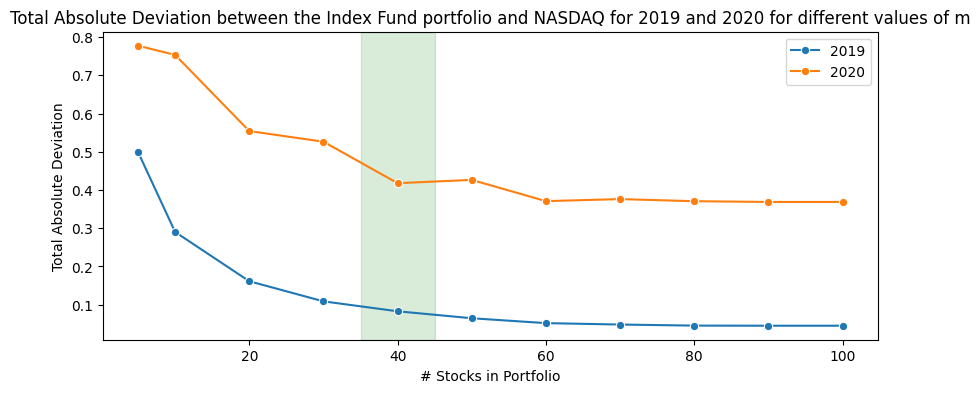

In [64]:
perf_2019_2 = np.array([float(x) for x in perf_2019_2])
perf_2020_2 = np.array([float(x) for x in perf_2020_2])

# Now we will plot the Total Absolute Deviation between the Index Fund portfolio and NASDAQ for 2019 and 2020 for different values of m
plt.figure(figsize=(10, 4))
sns.lineplot(x=summary_df.index.values, y=perf_2019_2, label="2019", marker="o")
sns.lineplot(x=summary_df.index.values, y=perf_2020_2, label="2020", marker="o")
plt.title("Total Absolute Deviation between the Index Fund portfolio and NASDAQ for 2019 and 2020 for different values of m")
plt.axvspan(35, 45, color='g', alpha=0.15)
plt.xlabel("# Stocks in Portfolio")
plt.ylabel("Total Absolute Deviation")
plt.legend()

Text(0, 0.5, 'Returns')

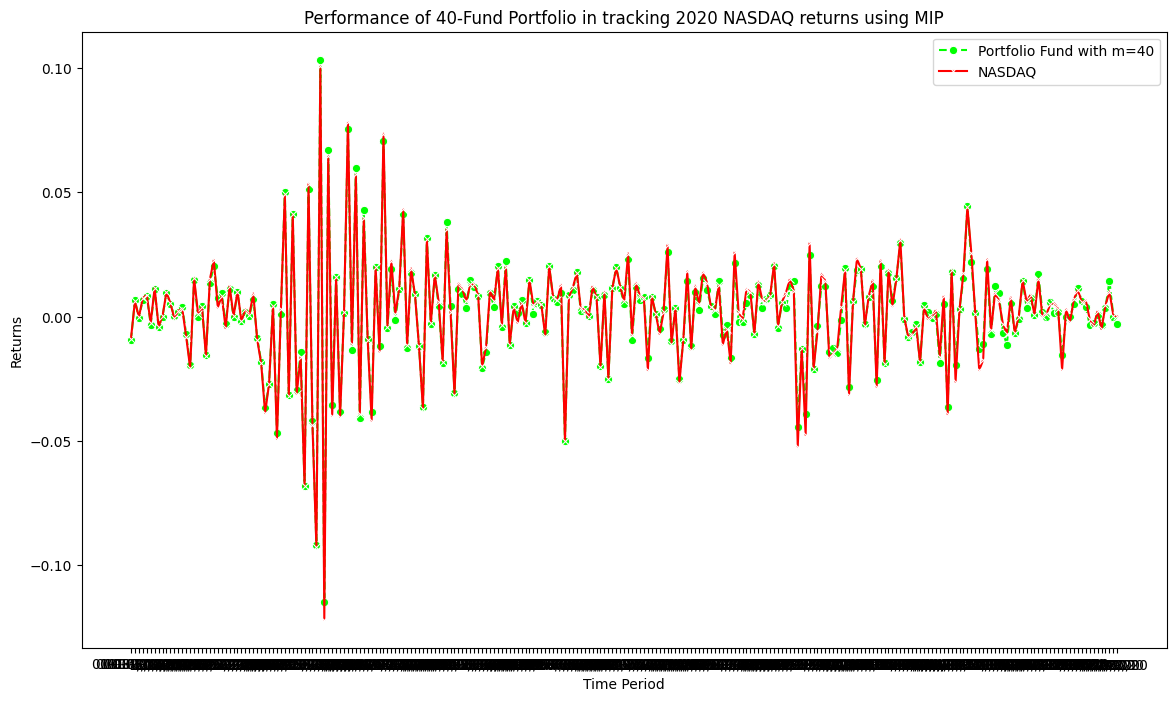

In [67]:
returns_timeline = data_2020_pct.index

plt.figure(figsize = (14,8))

#Plotting weighted returns from 2020 for selected stocks
sns.lineplot(x = returns_timeline, y = np.array(weighted_returns_best_model), marker = 'o', 
            linestyle = 'dashed', color = 'lime', label = 'Portfolio Fund with m=40')

#Plotting returns from 2020 for NASDAQ
sns.lineplot(x = returns_timeline, y = q_2020.ravel(), marker = 'x',
             color = 'red', label = 'NASDAQ')

plt.title("Performance of 40-Fund Portfolio in tracking 2020 NASDAQ returns using MIP")
plt.xlabel('Time Period')
plt.ylabel('Returns')